In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from argparse import ArgumentParser
from datasets import init_dataloaders
from models.detector import OVDDetector
from datasets import get_base_new_classes
from utils_dir.nms import custom_xywh2xyxy
from utils_dir.metrics import box_iou, compute_ap, smooth, ap_per_class
from utils_dir.processing_utils import map_labels_to_prototypes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import colorsys
from PIL import Image
import glob

/home/gridsan/manderson/.conda/envs/ovdsat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gridsan/manderson/.local/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/gridsan/manderson/.local/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  war

In [ ]:
#prototypes = torch.load('/home/gridsan/manderson/ovdsat/run/init_prototypes/boxes/dior_N5/prototypes_clip-14-gpte-512-epoch50.pt')

In [ ]:
#print(len(prototypes['label_names']))

### Helpers

In [2]:
# Create an ArgumentParser object
parser = ArgumentParser()

# Add your arguments as usual
parser.add_argument('--dataset', type=str)
parser.add_argument('--val_root_dir', type=str)
parser.add_argument('--val_annotations_file', type=str)
parser.add_argument('--annotations', type=str, default='box')
parser.add_argument('--prototypes_path', type=str)
parser.add_argument('--bg_prototypes_path', type=str, default=None)
parser.add_argument('--aggregation', type=str, default='mean')
parser.add_argument('--classification', type=str, default='box')
parser.add_argument('--save_dir', type=str, default=None)
parser.add_argument('--backbone_type', type=str, default='dinov2')
parser.add_argument('--target_size', nargs=2, type=int, metavar=('width', 'height'), default=[560, 560])
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--num_workers', type=int, default=8)
parser.add_argument('--scale_factor', nargs='+', type=int, default=[2])
parser.add_argument('--iou_thr', type=float, default=0.2)
parser.add_argument('--conf_thres', type=float, default=0.001)

_StoreAction(option_strings=['--conf_thres'], dest='conf_thres', nargs=None, const=None, default=0.001, type=<class 'float'>, choices=None, required=False, help=None, metavar=None)

In [3]:
def prepare_model(args):
    '''
    Loads the model to evaluate given the input arguments and returns it.
    
    Args:
        args (argparse.Namespace): Input arguments
    '''

    # Use GPU if available
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    # Load prototypes and background prototypes
    prototypes = torch.load(args.prototypes_path)
    print(f'Using object prototypes from {args.prototypes_path}')
    bg_prototypes = torch.load(args.bg_prototypes_path) if args.bg_prototypes_path is not None else None
    if args.bg_prototypes_path is not None:
        print(f'Using background prototypes from {args.bg_prototypes_path}')
    model = OVDDetector(prototypes, bg_prototypes, scale_factor=args.scale_factor, backbone_type=args.backbone_type, target_size=args.target_size, classification=args.classification, text=args.t).to(device)
    #model.eval() 
    return model, device

def process_batch(detections, labels, iouv, sc_cat=None):
    """
    Return correct prediction matrix
    Arguments:
        detections (array[N, 6]), x1, y1, x2, y2, conf, class (predicted)
        labels (array[M, 5]), class, x1, y1, x2, y2 (GT)
    Returns:
        correct (array[N, 10]), for 10 IoU levels
    """
    correct = np.zeros((detections.shape[0], iouv.shape[0])).astype(bool)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    correct_class = labels[:, 0:1] == detections[:, 5]
    for i in range(len(iouv)):
        x = torch.where((iou >= iouv[i]) & correct_class)  # IoU > threshold and classes match
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detect, iou]
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                # matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=iouv.device)

def generate_uniform_colors(n):
    """Generate n colors spread uniformly across the color spectrum in HSV space."""
    hsv_colors = np.zeros((n, 3))
    h_vals = np.linspace(0, 1, n)
    
    # Convert HSV to RGB
    # Saturation and Value are set to 1 for full color intensity
    rgb_colors = []
    for h in h_vals:
        rgb_colors.append(colorsys.hsv_to_rgb(h, 1, 1))
    
    return rgb_colors

def create_uniform_cmap(n):
    """Create a ListedColormap with n colors spread uniformly across the color spectrum."""
    colors = generate_uniform_colors(n)
    return ListedColormap(colors)

def viz_bbox_labels(img, boxes, labels, names, cmap, title=None, save_path=None):
    '''
    Args:
        img (array[x,y,3])
        boxes (array[N, 4])
        labels (array[N])
        names
        cmap 
        title (str)
    '''
    print(f'Visualizing {title}')
    
    img = img.cpu()
    boxes = boxes.cpu()
    labels = labels.cpu()
    
    # Create figure and axis
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(img)
    
    # Get unique labels and create colormap
    unique_labels = np.unique(labels)
    #cmap = ListedColormap([plt.cm.hsv(i / len(unique_labels)) for i in range(len(unique_labels))])
    
    # Iterate over each bounding box and draw rectangle and label
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        
        # Calculate box width and height
        box_width = x_max - x_min
        box_height = y_max - y_min
        
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor=cmap(int(label)), facecolor='none')
        
        # Add the patch to the plot
        ax.add_patch(rect)
        
        # Display label number next to the box
        ax.text(x_min, y_min, names[int(label.item())], fontsize=8, va='top', color='white', bbox=dict(facecolor=cmap(int(label)), alpha=0.5))
    
    # Set title
    ax.set_title(title)
    
    # Turn off the axis
    ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f'Saved image {save_path}')
    
    # Show the plt
    plt.show()

In [4]:
def reclassify(labels, sc_cat):
    '''
    labels: array of numerical labels
    sc_cat: nested array of indices belonging to each super class
    '''
    sc_labels = labels.clone()
    for i, sc in enumerate(sc_cat):
        for j, label_num in enumerate(labels):
            if label_num in sc:
                sc_labels[j] = i
    return sc_labels

In [5]:
def plot_images_with_gt(image_paths, grid_size, title=None, save_path=None):
    # Ensure the product of the dimensions matches the length of image_paths
    if len(image_paths) != grid_size[0] * grid_size[1]:
        raise ValueError("Grid size does not match the number of image paths")
        
    image_paths.sort() # alphabetical order for consistency

    # Find the index of the image with 'GT' in its filename
    gt_index = next((i for i, path in enumerate(image_paths) if 'GT' in os.path.basename(path)), None)
    
    if gt_index is not None:
        # Move the 'GT' image to the first position
        image_paths.insert(0, image_paths.pop(gt_index))

    # Load images
    images = [Image.open(path) for path in image_paths]

    # Create a plot with the specified grid size
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10,10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each image in the grid
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')  # Hide axes ticks

    # Remove any remaining empty subplots (if fewer than specified grid size)
    for ax in axes[len(images):]:
        ax.axis('off')

    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0,0.2,1,1.052])
    
    # Save image
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        print(f'Saving to {save_path}')
        
    # Display the plot
    plt.show()

### Normal eval code

In [6]:
def eval_detection(args, model, val_dataloader, device):
    seen = 0
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    nc = val_dataloader.dataset.get_category_number()
    names = model.classifier.get_categories()
    stats = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
            if args.classification != 'mask':
                images, boxes, labels, metadata = batch
                boxes = boxes.to(device)
            else:
                images, _, labels, masks, _ = batch
                loc = masks.float().to(device)
            
            labels = map_labels_to_prototypes(val_dataloader.dataset.get_categories(), model.classifier.get_categories(), labels)
            images = images.float().to(device)
            labels = labels.to(device)
            preds = model(images, iou_thr=args.iou_thr, conf_thres=args.conf_thres, aggregation=args.aggregation) #pred - x1, y1, x2, y2, conf, class
            for si, pred in enumerate(preds):
                keep = labels[si] > -1
                targets = labels[si, keep]
                nl, npr = targets.shape[0], pred.shape[0]  # number of labels, predictions
                correct = torch.zeros(npr, len(iouv), dtype=torch.bool, device=device)  # init
                seen += 1
                if npr == 0:
                    if nl:
                        stats.append((correct, *torch.zeros((2, 0), device=device), targets[:]))
                    continue
                    
                predn = pred.clone()
                if nl:
                    tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                    labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels (class, x1, y1, x2, y2)
                    correct = process_batch(predn, labelsn, iouv)
                stats.append((correct, pred[:, 4], pred[:, 5], targets[:]))
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy
    #mp, mr, map50, map, ap_class = 0, 0, 0, 0, 0
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  # print format
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    print(s)
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
    if args.save_dir is not None:
        os.makedirs(args.save_dir, exist_ok=True)
        filename = 'results_{}.txt'.format(args.backbone_type)
        save_file_path = os.path.join(args.save_dir, filename)
        base_classes, new_classes = get_base_new_classes(args.dataset)
        with open(save_file_path, 'w') as file:
            file.write('Class Images Instances P R mAP50 mAP50-95\n')
            file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('all', seen, nt.sum(), mp, mr, map50, map))
            if nc > 1 and len(stats):
                map50_base = map_base = mr_base = mp_base = 0
                map50_new = map_new = mr_new = mp_new = 0
                for i, c in enumerate(ap_class):
                    file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
                    if names[c] in base_classes:
                        map50_base += ap50[i]
                        map_base += ap[i]
                        mr_base += r[i]
                        mp_base += p[i]
                    elif names[c] in new_classes:
                        map50_new += ap50[i]
                        map_new += ap[i]
                        mr_new += r[i]
                        mp_new += p[i]
                map50_base /= len(base_classes)
                map_base /= len(base_classes)
                mr_base /= len(base_classes)
                mp_base /= len(base_classes)
                map50_new /= len(new_classes)
                map_new /= len(new_classes)
                mr_new /= len(new_classes)
                mp_new /= len(new_classes)
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total base', seen, nt.sum(), mp_base, mr_base, map50_base, map_base))
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total new', seen, nt.sum(), mp_new, mr_new, map50_new, map_new))

### Debug eval

In [6]:
def eval_detection_debug(args, model, val_dataloader, device):
    seen = 0
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    #print('iou levels:', iouv)
    nc = val_dataloader.dataset.get_category_number()
    #print(nc, 'categories in dataset')
    names = model.classifier.get_categories()
    print('Category names:', names)
    stats = []
    viz_cmap = create_uniform_cmap(nc)
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
            if i not in [1]:
                continue
            if args.classification != 'mask':
                images, boxes, labels, metadata = batch
                print(metadata)
                id = metadata['impath'][0][-8:-4]
                boxes = boxes.to(device)
            else:
                images, _, labels, masks, _ = batch
                loc = masks.float().to(device)
                
            print('Image shape:', images.shape)
            rgb = images[0].permute(1, 2, 0)
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
            #plt.imshow(rgb)
            
            print('Boxes shape:', boxes.shape)
            print('GT labels shape:', labels.shape)
            #print('GT labels:\n', labels)
            
            labels = map_labels_to_prototypes(val_dataloader.dataset.get_categories(), model.classifier.get_categories(), labels)
            images = images.float().to(device)
            labels = labels.to(device)
            preds = model(images, iou_thr=args.iou_thr, conf_thres=args.conf_thres, aggregation=args.aggregation)
            #print('Labels with prototype numbers:\n', labels)

            print('Pred - x1, y1, x2, y2, conf, class:', preds[0].shape)
            #print(preds[0])
            
            for si, pred in enumerate(preds):
                keep = labels[si] > -1
                #print(keep.shape)
                #print(keep)
                targets = labels[si, keep]
                #print('Targets (non-background GT objects):')
                #print(targets)
                nl, npr = targets.shape[0], pred.shape[0]  # number of labels, predictions
                print(nl, 'GT labels,', npr, 'predictions')
                if npr==0:
                    print('WARNING: no detections')
                correct = torch.zeros(npr, len(iouv), dtype=torch.bool, device=device)  # init
                seen += 1
                if npr == 0:
                    if nl:
                        stats.append((correct, *torch.zeros((2, 0), device=device), targets[:]))
                        tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                        labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels
                        viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT') #GT
                        viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, f'Predicted ({args.backbone_type})') # Predicted
                    continue
                    
                predn = pred.clone()
                #print('predn\n', predn)
                if nl:
                    tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                    #print('target boxes\n', tbox)
                    labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels
                    print('labelsn:', labelsn.shape)
                    #print(labelsn)
                    correct = process_batch(predn, labelsn, iouv) #correct (array[N, 10]), for 10 IoU levels for each prediction
                    print('correct:', correct.shape)
                    #print(correct)
                    
                # TODO insert viz script: call another function that takes in image, boxes, and labels for GT and prediction
                print('Visualizing')
                viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT') #GT
                viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, f'Predicted ({args.backbone_type})') # Predicted
                    
                stats.append((correct, pred[:, 4], pred[:, 5], targets[:]))
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy
    print('stats len', len(stats))
    print(stats)
    #for stat in stats:
    #    print(stat)
    print('Any correct detections?', stats[0].any())
    #if len(stats) and stats[0].any():
    if len(stats):
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names) # these results based on TPs and FPs of target (gt)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    else:
        print('WARNING: no correct detections.')
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  # print format
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    print(s)
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
    if args.save_dir is not None:
        os.makedirs(args.save_dir, exist_ok=True)
        filename = 'results_{}.txt'.format(args.backbone_type)
        save_file_path = os.path.join(args.save_dir, filename)
        base_classes, new_classes = get_base_new_classes(args.dataset)
        with open(save_file_path, 'w') as file:
            file.write('Class Images Instances P R mAP50 mAP50-95\n')
            file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('all', seen, nt.sum(), mp, mr, map50, map))
            if nc > 1 and len(stats):
                map50_base = map_base = mr_base = mp_base = 0
                map50_new = map_new = mr_new = mp_new = 0
                for i, c in enumerate(ap_class):
                    file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
                    if names[c] in base_classes:
                        map50_base += ap50[i]
                        map_base += ap[i]
                        mr_base += r[i]
                        mp_base += p[i]
                    elif names[c] in new_classes:
                        map50_new += ap50[i]
                        map_new += ap[i]
                        mr_new += r[i]
                        mp_new += p[i]
                map50_base /= len(base_classes)
                map_base /= len(base_classes)
                mr_base /= len(base_classes)
                mp_base /= len(base_classes)
                map50_new /= len(new_classes)
                map_new /= len(new_classes)
                mr_new /= len(new_classes)
                mp_new /= len(new_classes)
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total base', seen, nt.sum(), mp_base, mr_base, map50_base, map_base))
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total new', seen, nt.sum(), mp_new, mr_new, map50_new, map_new))

### Debug eval with superclasses

In [6]:
def eval_detection_debug_sc(args, model, val_dataloader, device):
    seen = 0
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
    #print('iou levels:', iouv)

    # Define superclass categories
    names = {
        0: 'car', 
        1: 'aircraft',
        2: 'boat',
        3: 'others'} 
    sc_cat = [[2,3,5,7,10,11,13],
              [0,1,8,9,12,14],
              [4],
              [6]]
              
    nc = len(names)
    print('Category names:', names)
    stats = []
    viz_cmap = create_uniform_cmap(nc)
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
            if i not in [0, 1, 3, 4, 80, 120, 240, 440, 500, 900]:
                continue
            if args.classification != 'mask':
                images, boxes, labels, metadata = batch
                print(metadata)
                id = metadata['impath'][0][-8:-4]
                boxes = boxes.to(device)
            else:
                images, _, labels, masks, _ = batch
                loc = masks.float().to(device)
                
            print('Image shape:', images.shape)
            rgb = images[0].permute(1, 2, 0)
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
            #plt.imshow(rgb)
            
            print('Boxes shape:', boxes.shape)
            print('GT labels shape:', labels.shape)
            #print('GT labels:\n', labels)
            
            labels = map_labels_to_prototypes(val_dataloader.dataset.get_categories(), model.classifier.get_categories(), labels)
            images = images.float().to(device)
            labels = labels.to(device)
            preds = model(images, iou_thr=args.iou_thr, conf_thres=args.conf_thres, aggregation=args.aggregation)
            #print('Labels with prototype numbers:\n', labels)

            print('Pred - x1, y1, x2, y2, conf, class:', preds[0].shape)
            #print(preds)
             
            for si, pred in enumerate(preds):
                keep = labels[si] > -1
                #print(keep.shape)
                #print(keep)
                targets = labels[si, keep]
                targets = reclassify(targets, sc_cat) # Reclassify using superclasses
                #print('Targets (non-background GT objects):')
                #print(targets)
                nl, npr = targets.shape[0], pred.shape[0]  # number of labels, predictions
                print(nl, 'GT labels,', npr, 'predictions')
                if npr==0:
                    print('WARNING: no detections')
                correct = torch.zeros(npr, len(iouv), dtype=torch.bool, device=device)  # init
                seen += 1
                if npr == 0:
                    if nl:
                        stats.append((correct, *torch.zeros((2, 0), device=device), targets[:]))
                        tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                        labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels
                        viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT') #GT
                        viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, f'Predicted ({args.backbone_type})') # Predicted
                    continue
                
                # Reclassify using superclasses
                pred[:,-1] = reclassify(pred[:,-1], sc_cat)
                #print('Reclassified pred\n', pred)
                    
                predn = pred.clone()
                if nl:
                    tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                    #print('target boxes\n', tbox)
                    labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels
                    print('labelsn:', labelsn.shape)
                    #print(labelsn)

                    correct = process_batch(predn, labelsn, iouv) #correct (array[N, 10]), for 10 IoU levels for each prediction
                    print('correct:', correct.shape)
                    #print(correct)
                    
                # TODO insert viz script: call another function that takes in image, boxes, and labels for GT and prediction
                print('Visualizing')
                viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT') #GT
                viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, f'Predicted ({args.backbone_type})') # Predicted
                    
                stats.append((correct, pred[:, 4], pred[:, 5], targets[:]))
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy
    print('stats len', len(stats))
    print(stats)
    #for stat in stats:
    #    print(stat)
    print('Any correct detections?', stats[0].any())
    #if len(stats) and stats[0].any():
    if len(stats):
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names) # these results based on TPs and FPs of target (gt)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    else:
        print('WARNING: no correct detections.')
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  # print format
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    print(s)
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
    if args.save_dir is not None:
        os.makedirs(args.save_dir, exist_ok=True)
        filename = 'results_{}.txt'.format(args.backbone_type)
        save_file_path = os.path.join(args.save_dir, filename)
        base_classes, new_classes = get_base_new_classes(args.dataset)
        with open(save_file_path, 'w') as file:
            file.write('Class Images Instances P R mAP50 mAP50-95\n')
            file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('all', seen, nt.sum(), mp, mr, map50, map))
            if nc > 1 and len(stats):
                map50_base = map_base = mr_base = mp_base = 0
                map50_new = map_new = mr_new = mp_new = 0
                for i, c in enumerate(ap_class):
                    file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
                    if names[c] in base_classes:
                        map50_base += ap50[i]
                        map_base += ap[i]
                        mr_base += r[i]
                        mp_base += p[i]
                    elif names[c] in new_classes:
                        map50_new += ap50[i]
                        map_new += ap[i]
                        mr_new += r[i]
                        mp_new += p[i]
                map50_base /= len(base_classes)
                map_base /= len(base_classes)
                mr_base /= len(base_classes)
                mp_base /= len(base_classes)
                map50_new /= len(new_classes)
                map_new /= len(new_classes)
                mr_new /= len(new_classes)
                mp_new /= len(new_classes)
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total base', seen, nt.sum(), mp_base, mr_base, map50_base, map_base))
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total new', seen, nt.sum(), mp_new, mr_new, map50_new, map_new))

### Run debug code

In [7]:
DATA_DIR='data'
backbone='remoteclip-14' #openclip-14 #dinov2 #georsclip-14 #remoteclip-14 #clip-14
dataset='dior'
finetune='coop_prototypes' #init_prototypes or train
finetune_type='boxes' #masks or boxes
N=10
M=1
#INIT_PROTOTYPES_PATH='run/init_prototypes'

In [8]:
args = parser.parse_args([
    '--dataset', dataset,
    '--val_root_dir', f'{DATA_DIR}/{dataset}/JPEGImages',
    '--save_dir', f'run/test/detection/{dataset}/{finetune}/backbone_{backbone}_{finetune_type}/N{N}-{M}',
    '--val_annotations_file', f'{DATA_DIR}/{dataset}/val_coco-{M}.json',
    '--prototypes_path', f'run/{finetune}/{finetune_type}/{dataset}_N{N}-{M}/prototypes_{backbone}.pt',
    #'--bg_prototypes_path', f'run/init_prototypes/boxes/{dataset}_N{N}-{M}/bg_prototypes_{backbone}.pt',
    '--backbone_type', backbone,
    '--classification', 'box',
    '--target_size', '602', '602',
    '--batch_size', '1',
    '--num_workers', '8',
    '--scale_factor', '1',
])

In [9]:
# if using CoOp
args.t = True

In [10]:
# Load data
_, val_dataloader = init_dataloaders(args)

In [11]:
# Load model
model, device = prepare_model(args)

Using object prototypes from run/coop_prototypes/boxes/dior_N10-1/prototypes_remoteclip-14.pt


In [12]:
model.classifier.backbone.logit_scale

Parameter containing:
tensor(4.6028, device='cuda:0')

Category names: {0: 'expressway service area', 1: 'expressway toll station', 2: 'airplane', 3: 'airport', 4: 'baseball field', 5: 'basketball court', 6: 'bridge', 7: 'chimney', 8: 'dam', 9: 'golf field', 10: 'ground track field', 11: 'harbor', 12: 'overpass', 13: 'ship', 14: 'stadium', 15: 'storage tank', 16: 'tennis court', 17: 'train station', 18: 'vehicle', 19: 'windmill'}


  0%|          | 0/14868 [00:00<?, ?it/s]

{'width': tensor([800]), 'height': tensor([800]), 'impath': ['data/dior/JPEGImages/19543.jpg']}
Image shape: torch.Size([1, 3, 602, 602])
Boxes shape: torch.Size([1, 500, 4])
GT labels shape: torch.Size([1, 500])


/home/gridsan/manderson/.local/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Pred - x1, y1, x2, y2, conf, class: torch.Size([135, 6])
1 GT labels, 135 predictions
labelsn: torch.Size([1, 5])
correct: torch.Size([135, 10])
Visualizing
Visualizing GT


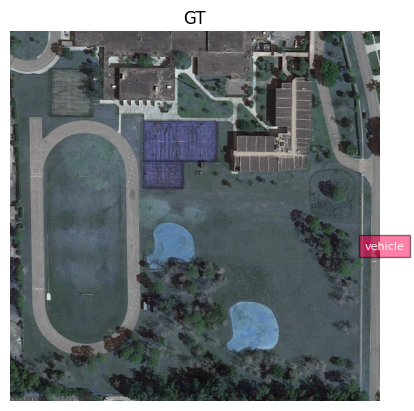

Visualizing Predicted (remoteclip-14)


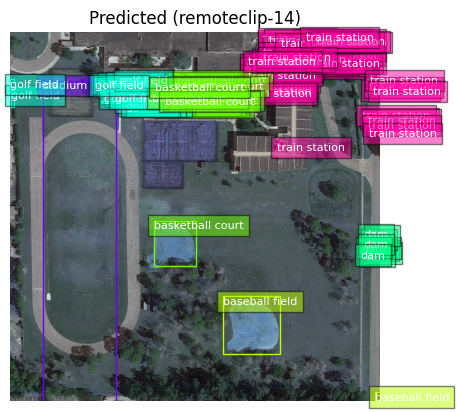

KeyboardInterrupt: 

In [13]:
# Walk through training
eval_detection_debug(
    args, 
    model, 
    val_dataloader, 
    device
)

### Unified function for eval

In [ ]:
def eval_detection_walkthru(args, model, val_dataloader, device, save_img=False, img_ids=None, sc=False):
    print(img_ids)
    seen = 0
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95

    # Define superclass categories
    if sc:
        if args.dataset == 'simd':
            names = {
                0: 'car', 
                1: 'aircraft',
                2: 'boat',
                3: 'others'} 
            sc_cat = [[2,3,5,7,10,11,13],
                      [0,1,8,9,12,14],
                      [4],
                      [6]]   
        nc = len(names)
    else:
        names = model.classifier.get_categories()
        print(names)
        nc = val_dataloader.dataset.get_category_number()
        sc_cat = None
        
    cat_type = '_sc' if sc else ''
    
    stats = []
    viz_cmap = create_uniform_cmap(nc)
    
    if 'gpt' in args.backbone_type:
        title='Ours'
    else:
        title=args.backbone_type
    
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
            print(i)
            if img_ids is None: # Only output first one
                if i > 50:
                    break
            if args.classification != 'mask':
                images, boxes, labels, metadata = batch
                id = metadata['impath'][0].split('/')[-1][:-4]
                if img_ids is None:
                    if i > 50:
                        break
                elif id not in img_ids:
                    continue
                print(metadata)
                boxes = boxes.to(device)
                #print('test 1')
            else:
                images, _, labels, masks, _ = batch
                loc = masks.float().to(device)
                #print('test 2')
            
            print('image shape here', images.shape)
            rgb = images[0].permute(1, 2, 0)
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
            
            labels = map_labels_to_prototypes(val_dataloader.dataset.get_categories(), model.classifier.get_categories(), labels)
            images = images.float().to(device)
            labels = labels.to(device)
            preds = model(images, iou_thr=args.iou_thr, conf_thres=args.conf_thres, aggregation=args.aggregation) #preds - x1, y1, x2, y2, conf, class:
             
            for si, pred in enumerate(preds):
                keep = labels[si] > -1
                targets = labels[si, keep]
                targets_orig = targets.clone()
                if sc:
                    targets = reclassify(targets, sc_cat) # Reclassify using superclasses
                nl, npr = targets.shape[0], pred.shape[0]  # number of labels, predictions
                print(nl, 'GT labels,', npr, 'predictions')
                if npr==0:
                    print('WARNING: no detections')
                correct = torch.zeros(npr, len(iouv), dtype=torch.bool, device=device)  # init
                seen += 1
                if npr == 0:
                    if nl:
                        stats.append((correct, *torch.zeros((2, 0), device=device), targets[:]))
                        tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                        labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels
                        
                        # Visualize anyway
                        if sc:
                            labelsn_orig = torch.cat((targets_orig[..., None], tbox), 1)
                            cmap_orig = create_uniform_cmap(val_dataloader.dataset.get_category_number())
                            viz_bbox_labels(rgb, tbox, labelsn_orig[:,0], model.classifier.get_categories(), cmap_orig, 'GT (Normal classes)') #GT
                            
                        if save_img:
                            viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT', save_path=f'figures/{dataset}/{id}_GT{cat_type}.jpg') #GT
                            viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, title, save_path=f'figures/{dataset}/{id}_{args.backbone_type}{cat_type}.jpg') # Predicted
                        else:
                            viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT') #save_path=f'figures/{dataset}/{id}_GT{cat_type}.jpg') #GT
                            viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, title) #save_path=f'figures/{dataset}/{id}_{args.backbone_type}{cat_type}.jpg') # Predicted
                    continue
                    
                predn = pred.clone()
                if sc:
                    predn[:,-1] = reclassify(predn[:,-1], sc_cat)
                if nl:
                    tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
                    labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels - class, x1, y1, x2, y2
                    #print('predn\n',predn)
                    #print('labelsn\n',labelsn)
                    
                    correct = process_batch(predn, labelsn, iouv, sc_cat) #correct (array[N, 10]), for 10 IoU levels for each prediction

                    #print('correct\n',correct)
                    
                # Visualize
                if sc:
                    labelsn_orig = torch.cat((targets_orig[..., None], tbox), 1)
                    cmap_orig = create_uniform_cmap(val_dataloader.dataset.get_category_number())
                    viz_bbox_labels(rgb, tbox, labelsn_orig[:,0], model.classifier.get_categories(), cmap_orig, 'GT (Normal classes)') #GT
                
                if save_img:
                    if not os.path.exists(f'figures/{dataset}'):
                        os.mkdir(f'figures/{dataset}')
                    viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT', save_path=f'figures/{dataset}/{id}_GT{cat_type}.jpg') #GT
                    viz_bbox_labels(rgb, predn[:,:4], predn[:,5], names, viz_cmap, title, save_path=f'figures/{dataset}/{id}_{args.backbone_type}{cat_type}.jpg') # Predicted
                else:
                    viz_bbox_labels(rgb, tbox, labelsn[:,0], names, viz_cmap, 'GT') #save_path=f'figures/{dataset}/{id}_GT{cat_type}.jpg') #GT
                    viz_bbox_labels(rgb, pred[:,:4], pred[:,5], names, viz_cmap, title) #save_path=f'figures/{dataset}/{id}_{args.backbone_type}{cat_type}.jpg') # Predicted

                print(pred[:,4])
                print(pred[:,5])
                print(targets_orig[:])
                stats.append((correct, pred[:, 4], pred[:, 5], targets_orig[:])) # correct, pred[:, 4] - confidence, pred[:, 5] - predicted classes, targets_orig[:] - true classes
                
    if sc:
        print('Using superclasses to evaluate')
    else:
        print('Using normal classes to evaluate')
    
    # Use original categories
    names = model.classifier.get_categories()
    nc = val_dataloader.dataset.get_category_number()
    
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  # to numpy

    if len(stats):
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, names=names) # classes based on predicted instances (not target)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    else:
        print('WARNING: no correct detections.')
    nt = np.bincount(stats[3].astype(int), minlength=nc)  # number of targets per class
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  # print format
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    print(s)
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
    if args.save_dir is not None:
        os.makedirs(args.save_dir, exist_ok=True)
        filename = 'results_{}.txt'.format(args.backbone_type)
        save_file_path = os.path.join(args.save_dir, filename)
        base_classes, new_classes = get_base_new_classes(args.dataset)
        with open(save_file_path, 'w') as file:
            file.write('Class Images Instances P R mAP50 mAP50-95\n')
            file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('all', seen, nt.sum(), mp, mr, map50, map))
            if nc > 1 and len(stats):
                map50_base = map_base = mr_base = mp_base = 0
                map50_new = map_new = mr_new = mp_new = 0
                for i, c in enumerate(ap_class):
                    file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))
                    if names[c] in base_classes:
                        map50_base += ap50[i]
                        map_base += ap[i]
                        mr_base += r[i]
                        mp_base += p[i]
                    elif names[c] in new_classes:
                        map50_new += ap50[i]
                        map_new += ap[i]
                        mr_new += r[i]
                        mp_new += p[i]
                map50_base /= len(base_classes)
                map_base /= len(base_classes)
                mr_base /= len(base_classes)
                mp_base /= len(base_classes)
                map50_new /= len(new_classes)
                map_new /= len(new_classes)
                mr_new /= len(new_classes)
                mp_new /= len(new_classes)
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total base', seen, nt.sum(), mp_base, mr_base, map50_base, map_base))
                file.write('%22s%11i%11i%11.4g%11.4g%11.4g%11.4g\n' % ('total new', seen, nt.sum(), mp_new, mr_new, map50_new, map_new))

#### Superclass Re-evaluation
* Results are based predicted original classes
* If a prediction is classified correctly into a superclass, it is counted as correct
* This correct goes toward to class stats for the original predicted class, not too the original target class

### Run eval of different models with same images

In [ ]:
DATA_DIR='data'
dataset='dior'
finetune='init_prototypes' #init_prototypes or train
finetune_type='boxes' #masks or boxes
save_img = True
N=5
M=3
INIT_PROTOTYPES_PATH='run/init_prototypes'

backbone_list = ['clip-14-gpt0-1024-epoch50', 'clip-14', 'openclip-14', 'georsclip-14', 'remoteclip-14'] 

sc = False # Whether or not to use superclasses
img_ids = None
#img_ids = ['02685', '06253', '10008', '04133', '04498', '22653', '05964', '22116', '05530', '16634', '07239', '13922', '05570', '18573', '17635', '08532', '21949', '17626', '22679', '19543', '14757', '01339', '11154', '22624', '22735', '07836', '06895', '11171', '07510', '05832', '02144', '01868', '03642', '18858', '16177', '00151', '15713', '12474', '12906', '18308', '23373', '05104', '12860', '07307', '06768', '13819', '11940', '21133', '03313', '09475', '06731', '08337']

In [ ]:
# Walk through training

for backbone in backbone_list:
    args = parser.parse_args([
    '--dataset', dataset,
    '--val_root_dir', f'{DATA_DIR}/{dataset}/JPEGImages',
    '--save_dir', f'run/test/detection/{dataset}/{finetune}/backbone_{backbone}_{finetune_type}/N{N}-{M}',
    '--val_annotations_file', f'{DATA_DIR}/{dataset}/val_coco-{M}.json',
    '--prototypes_path', f'run/{finetune}/{finetune_type}/{dataset}_N{N}-{M}/prototypes_{backbone}.pt',
    '--bg_prototypes_path', f'run/init_prototypes/boxes/{dataset}_N{N}-{M}/bg_prototypes_{backbone}.pt',
    '--backbone_type', backbone,
    '--classification', 'box',
    '--target_size', '602', '602',
    '--batch_size', '1',
    '--num_workers', '8',
    '--scale_factor', '1'
    ])
    
    # Load data
    _, val_dataloader = init_dataloaders(args)
    
    model, device = prepare_model(args)
    
    eval_detection_walkthru(
        args, 
        model, 
        val_dataloader, 
        device=device,
        save_img=True,
        img_ids=img_ids,
        sc=sc
    )

### Visualize all models

In [ ]:
folder_path = f'figures/{dataset}'

# List only files directly at the specified directory level
img_ids = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

img_ids = list(set([img_id.split('_')[0] for img_id in img_ids]))
print(img_ids)

In [ ]:
backbones = ['clip-14-gpt0-1024-epoch50', 'clip-14', 'openclip-14', 'georsclip-14', 'remoteclip-14', 'GT']
img_files = glob.glob(os.path.join(f'figures/{dataset}','*.jpg'))
save_path = f'figures/{dataset}/results'

if not os.path.exists(save_path):
    os.mkdir(save_path)

for id in img_ids:

    # Normal classes
    #filtered = [f for f in img_files if os.path.basename(f).startswith(id) and not os.path.basename(f).endswith('sc.jpg')]
    filtered = [f'figures/{dataset}/{id}_{bb}.jpg' for bb in backbones]
    print(filtered)   
    plot_images_with_gt(filtered, (2,3), f'Detections for {id}.jpg (Normal Classes)', f'{save_path}/{id}_all.jpg')

    if sc:
        # Superclasses
        #filtered = [f for f in img_files if os.path.basename(f).startswith(id) and os.path.basename(f).endswith('sc.jpg')]
        filtered = [f'figures/{dataset}/{id}_{bb}_sc.jpg' for bb in backbones]
        print(filtered)
        plot_images_with_gt(filtered, (2,3), f'Detections for {id}.jpg (Super Classes)', f'{save_path}/{id}_all_sc.jpg')